In [1]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory 
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------

# custom packages
import models.aux_funs as maf
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud
from models.fully_connected import fully_connected

# Fix the random seed

In [2]:
random_seed = 2
cf.seed_torch(random_seed)

# Configure the experiment

In [3]:
sparse_init = 0.01
r = [1,0.7/math.sqrt(sparse_init)]

conf_args = {#
    # data specification
    'data_file':"../../Data", 'train_split':0.80, 'data_set':"CIFAR10", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':0, 'cuda_device':0, 'pin_memory':True, 'train_split':0.80,
    #
    'epochs':100,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda':1e-3, 'optim':"LinBreg",'beta':0.0,
    # initialization
    'sparse_init':sparse_init, 'r':r,
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [4]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    

# Determine input size based on dataset
if conf.data_set == "CIFAR10":
    input_size = 3072  # 32x32x3
elif conf.data_set in ["MNIST", "FashionMNIST"]:
    input_size = 784   # 28x28x1
else:
    input_size = 784  # Default fallback
    
sizes = [input_size, 200, 80, 10]  # Dynamically set input size
act_fun = torch.nn.ReLU()
    
model = fully_connected(sizes, act_fun, **model_kwargs)
best_model = train.best_model(fully_connected(sizes, act_fun, **model_kwargs).to(conf.device))

# Weight initialization

In [5]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}    
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0,conf.r[0])
    maf.sparse_weight_normal_(model, conf.r[1])
    
    maf.sparsify_(model, conf.sparse_init)
    model = model.to(conf.device)
    return model

model = init_weights(conf,model)

# Optimizer

In [6]:
def init_opt(conf, model):
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)

    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda), 'momentum':conf.beta, 'delta':conf.delta},
                          {'params': biases, 'lr': conf.lr, 'momentum':conf.beta}])
    elif conf.optim == "LinBregHeavyBall":
        opt = op.LinBregHeavyBall([{'params': weights_linear, 'lr': conf.lr,
                                    'reg': reg.reg_l1(lamda=conf.lamda), 'momentum': conf.beta,
                                    'delta': conf.delta},
                                   {'params': biases, 'lr': conf.lr, 'momentum': conf.beta}])
    elif conf.optim == "adam":
        opt = op.AdaBreg([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD([{'params': weights_linear, 'lr' : conf.lr, 'reg' : reg.reg_l1(lamda=conf.lamda)},
                          {'params': biases, 'lr': conf.lr}])
    else:
        raise ValueError("Unknown Optimizer specified")

    # learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5,threshold=0.01)
    
    return opt, scheduler

# Dataset

In [7]:
train_loader, valid_loader, test_loader = ud.get_data_set(conf)

Files already downloaded and verified
Files already downloaded and verified


# History and Runs

In [8]:
# Initialize history
tracked = ['acc', 'loss', 'linear_sparse', 'reg_vals']

def reset_hist(tracked):
    train_hist = {}
    val_hist = {}
    return train_hist, val_hist

# Initialize runs
params = [
    # LinBreg Runs
    {'optim': 'LinBreg','reps':1, 'lamda': 1e-3, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-3)'}, # LinBreg, lamda:1e-3
    {'optim': 'LinBreg','reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-1)'}, # LinBreg, lamda:1e-1
    # SGD Runs (Equivalent to LinBreg with lamda = 0.0)
    {'optim': 'LinBreg','reps':1, 'lamda': 0.0, 'random_seed':0, 'label':'SGD'}, # SGD
    # ProxGD Runs
    {'optim': 'ProxSGD','reps':1, 'lamda': 1e-4, 'random_seed':0, 'label':'ProxSDG ($\lambda=1$e-4)'}, # ProxSGD, lamda:1e-4
    # LinBregHeavyBall Runs
    {'optim': 'LinBregHeavyBall', 'reps': 1, 'lamda': 1e-3, 'random_seed': 0, 'label': 'LinBregHeavyBall ($\lambda=1$e-3)'}, # LinBregHeavyBall, lamda:1e-3
    {'optim': 'LinBregHeavyBall', 'reps': 1, 'lamda': 1e-1, 'random_seed': 0, 'label': 'LinBregHeavyBall ($\lambda=1$e-1)'}, # LinBregHeavyBall, lamda:1e-1
]

runs = cf.run(params)

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:19: SyntaxWarning: invalid escape sequence '\l'
<>:20: SyntaxWarning: invalid escape sequence '\l'
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/960650000.py:12: SyntaxWarning: invalid escape sequence '\l'
  {'optim': 'LinBreg','reps':1, 'lamda': 1e-3, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-3)'}, # LinBreg, lamda:1e-3
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/960650000.py:13: SyntaxWarning: invalid escape sequence '\l'
  {'optim': 'LinBreg','reps':1, 'lamda': 1e-1, 'random_seed':0, 'label':'LinBreg ($\lambda=1$e-1)'}, # LinBreg, lamda

# Training

In [9]:
while runs.step(conf):
    # -----------------------------------------------------------------------------------
    # Reinit weigts and the corresponding optimizer
    # -----------------------------------------------------------------------------------
    train_hist, val_hist = reset_hist(tracked)
    model = init_weights(conf, model)
    opt, scheduler = init_opt(conf, model)
    
    # -----------------------------------------------------------------------------------
    # train the model
    # -----------------------------------------------------------------------------------
    for epoch in range(conf.epochs):
        print(25*"<>")
        print(50*"|")
        print(25*"<>")
        print('Epoch:', epoch)

        # ------------------------------------------------------------------------
        # train step, log the accuracy and loss
        # ------------------------------------------------------------------------
        train_data = train.train_step(conf, model, opt, train_loader)

        # update history
        for key in tracked:
            if key in train_data:
                var_list = train_hist.setdefault(key, [])
                var_list.append(train_data[key])        

        # ------------------------------------------------------------------------
        # validation step
        val_data = train.validation_step(conf, model, opt, valid_loader)

        # update history
        for key in tracked:
            
            
            if key in val_data:
                var = val_data[key]
                if isinstance(var, list):
                    for i, var_loc in enumerate(var):
                        key_loc = key+"_" + str(i)
                        var_list = val_hist.setdefault(key_loc, [])
                        val_hist[key_loc].append(var_loc)
                else:
                    var_list = val_hist.setdefault(key, [])
                    var_list.append(var)    

        # scheduler step
        scheduler.step(train_data['loss'])
        print("Learning rate:",opt.param_groups[0]['lr'])
        
        # update beset model
        best_model(train_data['acc'], val_data['acc'], model=model)

        
    # add values to the run history
    runs.add_history(train_hist, "train")
    runs.add_history(val_hist, "val")
            
    # update random seed
    cf.seed_torch(conf.random_seed)

<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 0
--------------------------------------------------
Train Accuracy: 0.2829
Train Loss: 629.1972036361694
--------------------------------------------------
Validation Accuracy: 0.2932
Non-zero kernels: 0
Linear sparsity: 0.3307652091254753
Overall sparsity: 0.3307652091254753
Node sparsity: [1.0, 0.925, 1.0]
Regularization values per group: [1.6852454948425293, 0.0]
Learning rate: 0.1
<><><><><><><><><><><><><><><><><><><><><><><><><>
||||||||||||||||||||||||||||||||||||||||||||||||||
<><><><><><><><><><><><><><><><><><><><><><><><><>
Epoch: 1
--------------------------------------------------
Train Accuracy: 0.348075
Train Loss: 571.2843860387802
--------------------------------------------------
Validation Accuracy: 0.3607
Non-zero kernels: 0
Linear sparsity: 0.4811977186311787
Overall sparsity: 0.4811977186311787
Node sparsi

# Prepare Data
In this step we average over different runs of the same parameter configuration.

In [10]:
import numpy as np

hist = runs.history
keys = ['train_acc','val_acc','val_reg_vals_0','val_linear_sparse']


hist_idx = 0
for param in params:
    data = {}
    for key in keys:
        if not key in hist[hist_idx]:
            continue
        
        if key == 'train_acc' or key == 'val_acc' or key == 'val_linear_sparse':
            rescale = 100
        else:
            rescale = 1/param['lamda'] if param['lamda'] > 0.0 else 0.0
            
        n = len(hist[hist_idx][key])
        m = param.get('reps',1)
        data_loc = np.zeros(shape=(n,m))
        
        # assign data and save it into local array for mean and average
        for i in range(m):
            var = np.array(hist[hist_idx + i][key])
            data_loc[:,i] = rescale*var
            data[key+"_run_" + str(i)] = rescale*var

        # mean and std of the data
        data[key+"_mean"] = np.mean(data_loc,axis=1)
        data[key+"_std"] = np.std(data_loc,axis=1)
        
        param['result'] = data
        
        # update the history index
    hist_idx += m

# Setup plots and appearance

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('default')
plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=8
matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 2
matplotlib.rcParams['text.color'] = 'black'

In [12]:
def plot_training_stats(ax, keys, data, label='', color='k',alpha=1.0, alpha_fill=0.2):
    for i in range(len(keys)):
        if not (keys[i]+'_mean') in data:
            continue
        # --------------------------------
        var_mean = data[keys[i]+'_mean']
        var_std = data[keys[i]+'_std']
        # --------------------------------
        epochs = np.arange(len(var_mean))
        ax[i].plot(epochs,var_mean, label=label, color=color,alpha=alpha)
        ax[i].fill_between(epochs, var_mean - var_std, var_mean + var_std, color=color, alpha=alpha_fill)

# Colors

In [13]:
cmp = matplotlib.cm.get_cmap(name='Accent')
colors = [
    cmp(0.7), #
    cmp(0.4), #
    cmp(0.0), #
    cmp(0.2), #
    cmp(0.8), #
    cmp(0.8), #
    cmp(0.3), #
]

for i, param in enumerate(params):
    param['color'] = colors[i]
    param.setdefault('label', param['optim'])

/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/3754096573.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmp = matplotlib.cm.get_cmap(name='Accent')


# Final Plot

<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/3934948103.py:16: SyntaxWarning: invalid escape sequence '\e'
  ax[2].set_ylabel('$\ell_1$-Norm')


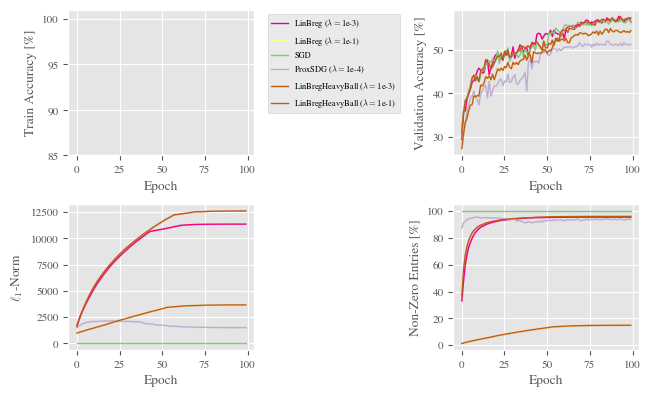

In [14]:
fig, ax = plt.subplots(2, 2)
ax = np.ravel(ax)

for param in params:
    plot_training_stats(ax, keys, param['result'], color=param['color'], label=param['label'])

# Specify axes
## Train Acc
ax[0].set_ylabel('Train Accuracy [%]')
ax[0].set_xlabel('Epoch')
ax[0].set_ylim(85, 101)
## Validation Acc
ax[1].set_ylabel('Validation Accuracy [%]')
ax[1].set_xlabel('Epoch')
## L1-Norm
ax[2].set_ylabel('$\ell_1$-Norm')
ax[2].set_xlabel('Epoch')
## Sparsity
ax[3].set_ylabel('Non-Zero Entries [%]')
ax[3].set_xlabel('Epoch')

# Legend: Move outside the plot area and reduce font size
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles, labels, loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 6}, ncol=1)

# Adjust size
width = 5.50107 / 0.8
height = 8.02778 / (2.0)
fig.set_size_inches(width, height)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.95, 1])

# Change color of one of the LinBregHeavyBall lines to blue
params[5]['color'] = 'blue'  # Change the color of the second LinBregHeavyBall

In [15]:
import pandas as pd

optimizer_labels = [
    'LinBreg ($\lambda=1$e-3)',
    'LinBreg ($\lambda=1$e-1)',
    'SGD',
    'ProxSGD ($\lambda=1$e-4)',
    'LinBregHeavyBall ($\lambda=1$e-3)',
    'LinBregHeavyBall ($\lambda=1$e-1)'
]

records = []

# Each run's history is stored in runs.history.
# We assume that for each run:
#    - run['label'] is the optimizer label (e.g., "LinBreg ($\lambda=1$e-3)")
#    - run['lamda'] is the regularization parameter value
#    - run['train_acc'] and run['val_acc'] store the final accuracies.
#    - run['val_linear_sparse'] stores the sparsity level.
for i, run in enumerate(runs.history):
    label = optimizer_labels[i % len(optimizer_labels)]  # Use modulo to handle repetitions
    sparsity = run.get('val_linear_sparse', [None])[-1]
    train_acc = run.get('train_acc', [None])[-1]
    val_acc = run.get('val_acc', [None])[-1]
    
    records.append({
        'Optimizer': label,
        'Sparsity Level': sparsity,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    })

df = pd.DataFrame(records)
print(df)

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/3513129477.py:4: SyntaxWarning: invalid escape sequence '\l'
  'LinBreg ($\lambda=1$e-3)',
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/3513129477.py:5: SyntaxWarning: invalid escape sequence '\l'
  'LinBreg ($\lambda=1$e-1)',
/var/folders/qb/nfbsnvhj253bvsh4w4c9g65w0000gn/T/ipykernel_5334/3513129477.py:7: SyntaxWarning: invalid escape sequence '\l'
  'ProxSGD ($\lambda=1$e-4)',
/var/folders/qb/nfbsnvhj253bvsh4w4c

                           Optimizer  Sparsity Level  Train Accuracy  \
0           LinBreg ($\lambda=1$e-3)        0.954073        0.597750   
1           LinBreg ($\lambda=1$e-1)        0.149411        0.556300   
2                                SGD        1.000000        0.596025   
3           ProxSGD ($\lambda=1$e-4)        0.937315        0.520700   
4  LinBregHeavyBall ($\lambda=1$e-3)        0.959422        0.602425   
5  LinBregHeavyBall ($\lambda=1$e-1)        0.149411        0.556300   

   Validation Accuracy  
0               0.5649  
1               0.5448  
2               0.5632  
3               0.5127  
4               0.5739  
5               0.5448  
